In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.decomposition import PCA
from matplotlib import rcParams
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import rcParams
from sklearn.feature_selection import SelectKBest
from scipy import stats
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn import metrics

from google.colab import files
import io

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [0]:
# Set graph parameters
sns.set_style('whitegrid')
rcParams['figure.figsize'] = 10,7

In [3]:
uploaded = files.upload()

Saving cardio_train.csv to cardio_train.csv


In [4]:
# store data and take a look
df = pd.read_csv(io.BytesIO(uploaded['cardio_train.csv']), sep=';')
print(df.shape)
df.head()

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Some information about the features
- Age is currently measured in days
- Gender is classified 1:women and 2:men
- Height is measure in cm
- Weight is measured in kg 
- ap_hi refers to arterial pressure. Specifically the Systolic blood pressures which represents when the heart contracts.
- ap_lo refers to Dystolic Blood Pressure or when the heart contracts. 
    - ap_hi and ap_lo are used to calculate blood pressure (e.g. 120/80)
    - according to the CDC, less than 120/80 is considered normal, between 120/80 and 139/89 is considered at risk for high blood pressure, and more than 140/90 is considered high blood pressure.
- cholesterol and glu are labeled as 1:normal, 2:above normal, 3 well above normal.
- smoke, alco, active, and cardio are binary with cardio as the target

# Data Cleaning

In [5]:
# Change age to years for easier comprehension 
df['age'] = round(df['age'] / 365, 1)

# Add BMI metric for later
df['bmi'] = (df['weight'] / df['height'] / df['height']) * 10000

# Look at shape
print(df.shape)

# Look at general statitics
df.describe()

(70000, 14)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.339486,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.556513
std,28851.302323,6.759534,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.091511
min,0.000000,29.600000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784
25%,25006.750000,48.400000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,50001.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.374068
75%,74889.250000,58.400000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.222222
max,99999.000000,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667


In [6]:
# Look for missing values
df.isnull().any()

id             False
age            False
gender         False
height         False
weight         False
ap_hi          False
ap_lo          False
cholesterol    False
gluc           False
smoke          False
alco           False
active         False
cardio         False
bmi            False
dtype: bool

There appears to be some outliers in the blood pressure features

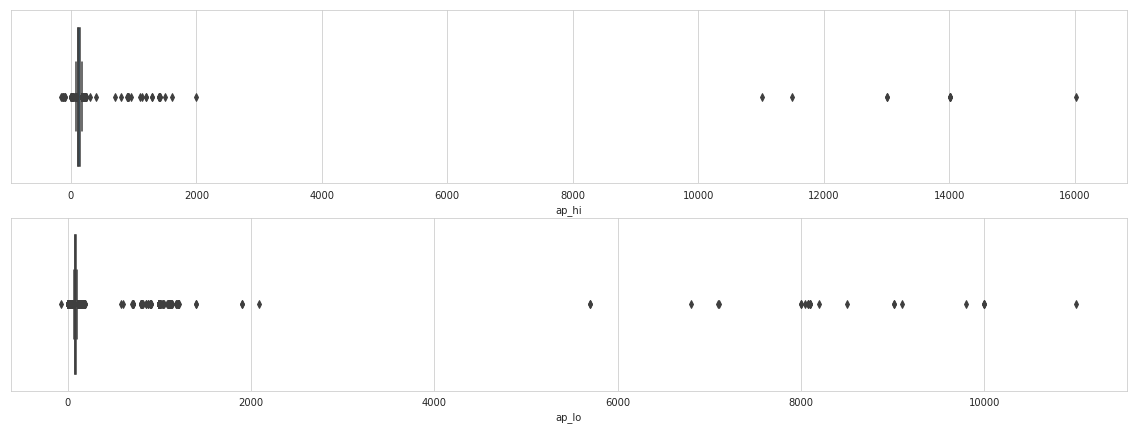

In [7]:
plt.figure(figsize=(20,7))
plt.subplot(211)
sns.boxplot(df['ap_hi'])
plt.subplot(212)
sns.boxplot(df['ap_lo'])

In [8]:
# Determine parameters for removing outliers and how many observations would be removed
print(df[df['ap_hi'] > 370].shape)
print(df[df['ap_lo'] > 360].shape)
print(df[df['ap_hi'] < 0].shape)
print(df[df['ap_lo'] < 0].shape)
print(df[df['ap_hi'] < df['ap_lo']].shape)


(39, 14)
(953, 14)
(7, 14)
(1, 14)
(1234, 14)


When looking for a threshold for how high blood pressure can be, the highest record found comes from an article in the NCBI (National Center for Biotechnology Information) on breathing techniques where they had participants perform strenuous exercises. The highest record measurement was 370/360 and since other extreme blood pressures on record weren't found, this measurement served as the threshold.

https://www.ncbi.nlm.nih.gov/pubmed/7741618


I also removed any blood pressure which was negative and any occurance of ap_hi being lower than ap_lo.

For the cleaning procedure, I opted to remove these outliers as opposed to imputing values. On a close inspection it seemed like some of the blood pressure values were simply recorded incorrectly. Rather than assuming that the person who recorded the values had simply mis-typed, I instead removed the values as it seemed safer and maintained the overall integrety of the dataset. 

In [9]:
# Create copies for modeling 
df_clean = df.copy()
df_full = df.copy()

# Drop blood pressure outliers
df_clean.drop(df_clean[(df_clean['ap_hi'] > 370)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['ap_lo'] > 360)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['ap_hi'] < 0)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['ap_lo'] < 0)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['ap_hi'] < df_clean['ap_lo'])].index,inplace=True)

first_cleaning = 1 - df_clean.shape[0] / df.shape[0]
print(df_clean.shape)
print('Percent of observations lost:', first_cleaning)

(68726, 14)
Percent of observations lost: 0.018199999999999994


Here I check to see how much of the origianl dataset I loose by removing outliers

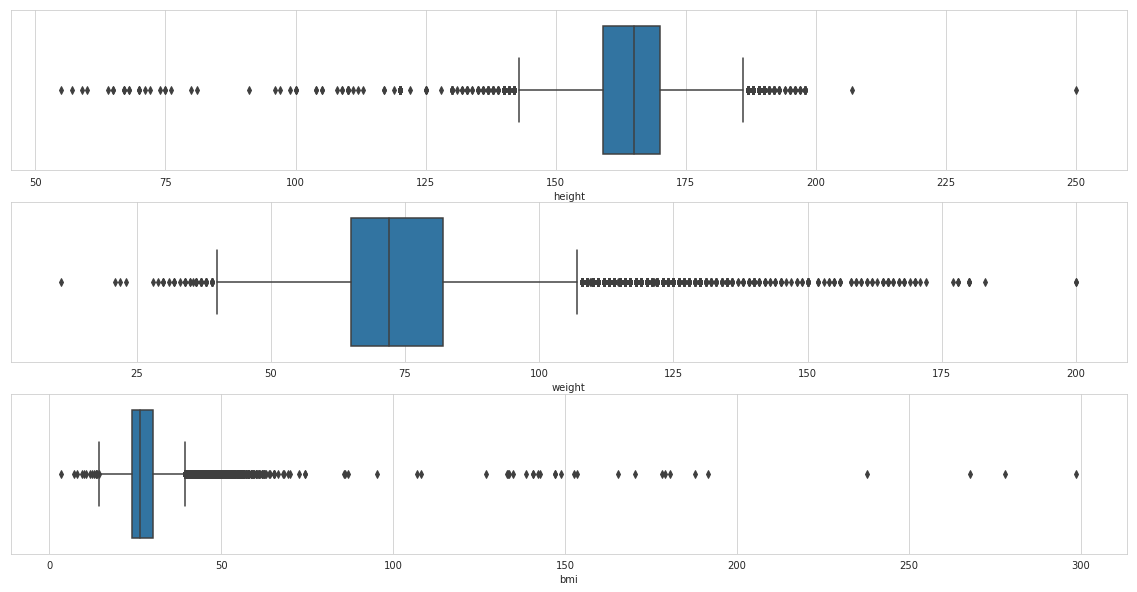

In [10]:
# Look at the outliers in weight and height
plt.figure(figsize=(20, 10))
plt.subplot(311)
sns.boxplot(df_clean['height'])
plt.subplot(312)
sns.boxplot(df_clean['weight'])
plt.subplot(313)
sns.boxplot(df_clean['bmi']);

In [11]:
# See what kind of impact removing these observations would make 
print(df_clean[df_clean['height'] < 100].shape)
print(df_clean[df_clean['height'] > 225].shape)
print(df_clean[df_clean['weight'] < 40].shape)
print(df_clean[df_clean['weight'] > 175].shape)
print(df_clean[df_clean['bmi'] > 45].shape)
print(df_clean[df_clean['bmi'] < 15].shape)

(27, 14)
(1, 14)
(49, 14)
(11, 14)
(579, 14)
(26, 14)


I do the same method for the height and weight, but was more forgiving in terms of the outliers. 
100cm came out just above 3ft
225 only had one outlier past 7ft
40 kg came out to around 88 lbs
175 kg came out to around 385 lbs

and then I set limits and those where are dangerously obese and dangerously overweight




Because I didn't want to jeoparodize the integrety of the dataset I run my models with and without feature engineering in order to see if there is drastic effect on the models' ability to predict.

In [51]:
# Drop outliers from weight and height
df_clean.drop(df_clean[(df_clean['height'] < 100)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['height'] > 225)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['weight'] < 40)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['weight'] > 175)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['bmi'] > 45)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['bmi'] < 15)].index,inplace=True)

# Determine percentage of outliers removed
print(df_clean.shape)
print('Percent missing from origianl:', 1 - df_clean.shape[0] / df.shape[0])


(68082, 14)
Percent missing from origianl: 0.02739999999999998


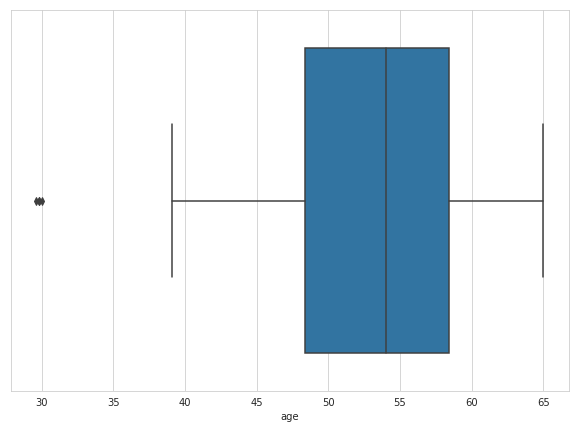

In [13]:
# Look at the outliers in age
sns.boxplot(df_clean['age'])

In [14]:
df_clean[df_clean['age']<35].shape

(4, 14)

In [0]:
df_clean.drop(df_clean[(df_clean['age']<35)].index,inplace=True)

# Exploratory Data Analysis

Text(0.5, 0, 'Age')

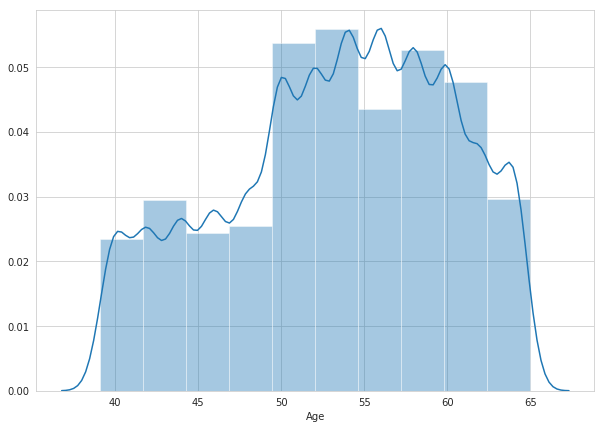

In [16]:
# Look at the distribution of age
sns.distplot(df_clean['age'], bins=10)
plt.xlabel('Age')

Here we can see that there are more individuals 50 years old or older in the dataset.

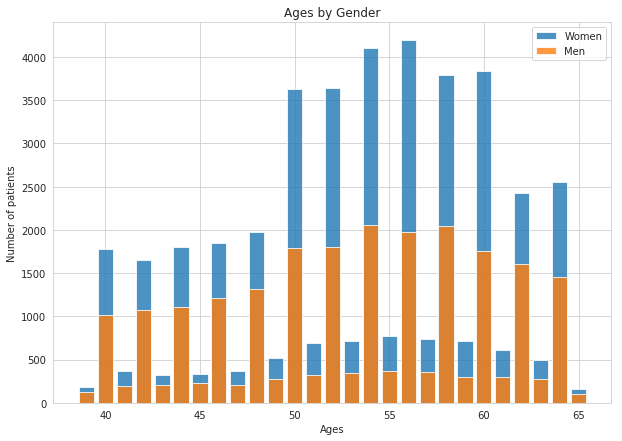

In [33]:
years = round(df_clean[df_clean['gender']==1]['age']).value_counts().index
ages_women = round(df_clean[df_clean['gender']==1]['age']).value_counts()
plt1 = plt.bar(years, ages_women, alpha=.8)

years = round(df_clean[df_clean['gender']==2]['age']).value_counts().index
ages_men = round(df_clean[df_clean['gender']==2]['age']).value_counts()
plt2 = plt.bar(years, ages_men, alpha=.8)

plt.ylabel('Number of patients')
plt.xlabel('Ages')
plt.title('Ages by Gender')
plt.legend((plt1[0], plt2[0]), ('Women', 'Men'))

plt.show()

Here we can see the same distribution, but now delineated by gender. There appear to be more women in every age category.

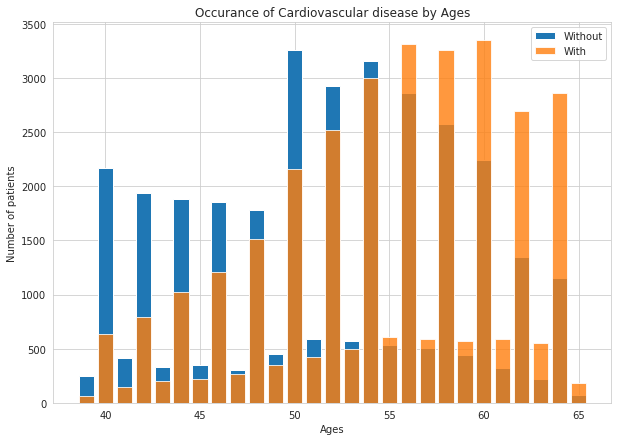

In [42]:
years = round(df_clean[df_clean['cardio']==0]['age']).value_counts().index
without_cardio = round(df_clean[df_clean['cardio']==0]['age']).value_counts()
plt1 = plt.bar(years, without_cardio)

years = round(df_clean[df_clean['cardio']==1]['age']).value_counts().index
with_cardio = round(df_clean[df_clean['cardio']==1]['age']).value_counts()
plt2 = plt.bar(years, with_cardio, alpha=.8)

plt.ylabel('Number of patients')
plt.xlabel('Ages')
plt.title('Occurance of Cardiovascular disease by Ages')
plt.legend((plt1[0], plt2[0]), ('Without', 'With'))

plt.show()

Another interesting thing we can look at is the age when more people have cardiovascular diesease as oppsed to those who do not. Those with cardiovascular disease consistently rises and eventually surpasses those who don't around the age of 55 and stays at a relatively high level while those without steadily decreases

In [52]:

df_clean.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50.4,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55.4,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,51.7,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48.3,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,47.9,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


Take one last look at the frist 5 observations

In [0]:
print(df_clean.shape)
print(df_full.shape)

(68082, 14)
(70000, 14)


Take a look at how the overall shape has changed through the cleaning. A total of 1,918 observations have been removed or 2.74%

In [0]:
for col in df_clean.drop(['id', 'cardio'],1):
  print(col)
  print(stats.ttest_ind(df_clean[col], df_clean['cardio']))
  print()

age
Ttest_indResult(statistic=2033.4073659785386, pvalue=0.0)

gender
Ttest_indResult(statistic=323.56990464565314, pvalue=0.0)

height
Ttest_indResult(statistic=5460.787385941692, pvalue=0.0)

weight
Ttest_indResult(statistic=1413.2373633130717, pvalue=0.0)

ap_hi
Ttest_indResult(statistic=1974.0749819335695, pvalue=0.0)

ap_lo
Ttest_indResult(statistic=2190.226055397503, pvalue=0.0)

cholesterol
Ttest_indResult(statistic=269.3877941766403, pvalue=0.0)

gluc
Ttest_indResult(statistic=251.46467680450004, pvalue=0.0)

smoke
Ttest_indResult(statistic=-183.9075527126967, pvalue=0.0)

alco
Ttest_indResult(statistic=-209.46958137073025, pvalue=0.0)

active
Ttest_indResult(statistic=126.66795586543361, pvalue=0.0)

bmi
Ttest_indResult(statistic=1435.0156927356975, pvalue=0.0)



Look at the t-statistic and p-values in relation to target value.

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
id,1.000000,0.002950,0.003128,-0.002307,-0.000429,0.001251,-0.000160,0.005693,0.001488,-0.003923,-0.000017,0.003888,0.003770,0.000503
age,0.002950,1.000000,-0.022427,-0.085418,0.058103,0.209780,0.154515,0.154929,0.098679,-0.047166,-0.028195,-0.009925,0.239762,0.109246
gender,0.003128,-0.022427,1.000000,0.521150,0.176248,0.064864,0.068321,-0.035272,-0.020067,0.338968,0.170803,0.005881,0.008466,-0.105900
height,-0.002307,-0.085418,0.521150,1.000000,0.340105,0.020854,0.038301,-0.054406,-0.019458,0.195724,0.098401,-0.009388,-0.010980,-0.192217
weight,-0.000429,0.058103,0.176248,0.340105,1.000000,0.264736,0.246487,0.138576,0.101126,0.072995,0.070573,-0.018724,0.180094,0.853040
ap_hi,0.001251,0.209780,0.064864,0.020854,0.264736,1.000000,0.718885,0.193426,0.091329,0.028877,0.035885,-0.000658,0.427194,0.264667
ap_lo,-0.000160,0.154515,0.068321,0.038301,0.246487,0.718885,1.000000,0.157358,0.072154,0.026094,0.036875,-0.001034,0.334019,0.236193
cholesterol,0.005693,0.154929,-0.035272,-0.054406,0.138576,0.193426,0.157358,1.000000,0.449108,0.010244,0.035562,0.009126,0.221305,0.173265
gluc,0.001488,0.098679,-0.020067,-0.019458,0.101126,0.091329,0.072154,0.449108,1.000000,-0.006073,0.009937,-0.007443,0.088950,0.115171
smoke,-0.003923,-0.047166,0.338968,0.195724,0.072995,0.028877,0.026094,0.010244,-0.006073,1.000000,0.341268,0.025281,-0.016048,-0.032509


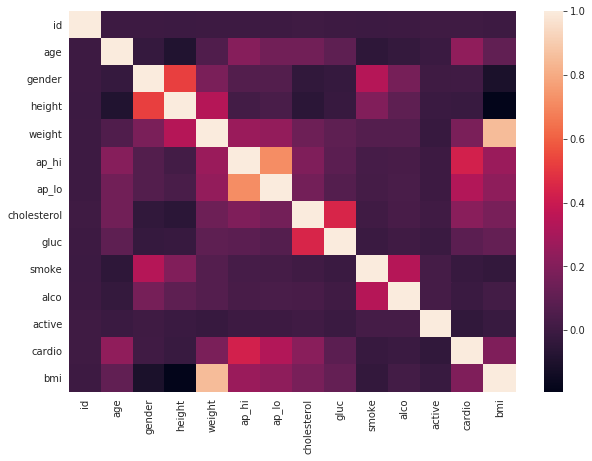

In [0]:
corrmat = df_clean.corr()
sns.heatmap(corrmat)
corrmat

Looking at which features have high colinearity between one another. Since BMI was only calculated to remove outliers, it will be dropped. Ap_hi and ap_lo have some colinearity as well as weight and gender. 

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
age,1.000000,-0.022427,-0.085418,0.058103,0.209780,0.154515,0.154929,0.098679,-0.047166,-0.028195,-0.009925
gender,-0.022427,1.000000,0.521150,0.176248,0.064864,0.068321,-0.035272,-0.020067,0.338968,0.170803,0.005881
height,-0.085418,0.521150,1.000000,0.340105,0.020854,0.038301,-0.054406,-0.019458,0.195724,0.098401,-0.009388
weight,0.058103,0.176248,0.340105,1.000000,0.264736,0.246487,0.138576,0.101126,0.072995,0.070573,-0.018724
ap_hi,0.209780,0.064864,0.020854,0.264736,1.000000,0.718885,0.193426,0.091329,0.028877,0.035885,-0.000658
ap_lo,0.154515,0.068321,0.038301,0.246487,0.718885,1.000000,0.157358,0.072154,0.026094,0.036875,-0.001034
cholesterol,0.154929,-0.035272,-0.054406,0.138576,0.193426,0.157358,1.000000,0.449108,0.010244,0.035562,0.009126
gluc,0.098679,-0.020067,-0.019458,0.101126,0.091329,0.072154,0.449108,1.000000,-0.006073,0.009937,-0.007443
smoke,-0.047166,0.338968,0.195724,0.072995,0.028877,0.026094,0.010244,-0.006073,1.000000,0.341268,0.025281
alco,-0.028195,0.170803,0.098401,0.070573,0.035885,0.036875,0.035562,0.009937,0.341268,1.000000,0.025004


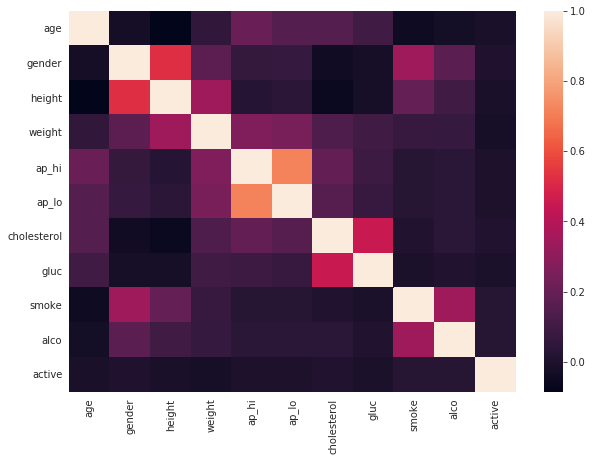

In [0]:
# Create features and target variables
X_clean = df_clean.drop(['id', 'cardio', 'bmi'], 1)
y_clean = df_clean.cardio

X_full = df_full.drop(['id', 'cardio', 'bmi'], 1)
y_full = df_full['cardio']

# Look at a correlation matrix and heatmap of correlation between feature variables
corrmat_clean = X_clean.corr()
sns.heatmap(corrmat_clean);
corrmat_clean

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
age,1.000000,-0.022794,-0.081522,0.053654,0.020778,0.017630,0.154394,0.098672,-0.047638,-0.029730,-0.009931
gender,-0.022794,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866
height,-0.081522,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570
weight,0.053654,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867
ap_hi,0.020778,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033
ap_lo,0.017630,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780
cholesterol,0.154394,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911
gluc,0.098672,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770
smoke,-0.047638,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858
alco,-0.029730,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476


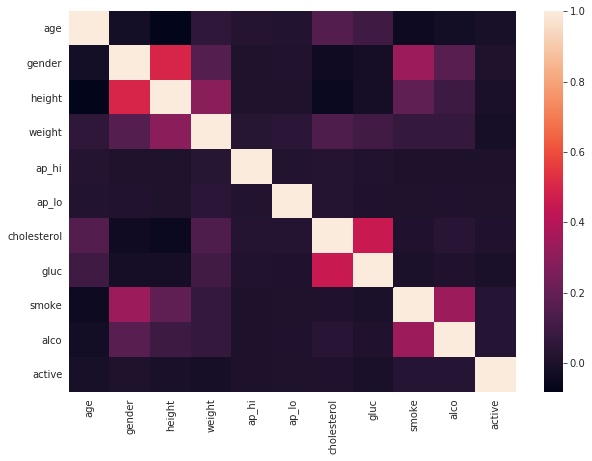

In [0]:
corrmat_full = X_full.corr()
sns.heatmap(corrmat_full);
corrmat_full

A comparison to see what the correlation between features are with the full/uncleaned dataset. Because the two heatmaps look similar, the modeling section will contain models built with the full and cleaned datasets.

# Modeling


### Feature Selection

In [0]:
# Use SelectKBest to find the 10 most significant features for the cleaned dataset
X_new = SelectKBest(k=10).fit_transform(X_clean, y_clean)
Kbest_X_clean = pd.DataFrame(X_new)
Kbest_X_clean.head()

,0,1,2,3,4,5,6,7,8,9
0,50.4,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,1.0
1,55.4,1.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,1.0
2,51.7,1.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0
3,48.3,2.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,1.0
4,47.9,1.0,156.0,56.0,100.0,60.0,1.0,1.0,0.0,0.0


In [0]:
# Same but for the full dataset
X_new = SelectKBest(k=10).fit_transform(X_full, y_full)
Kbest_X_full = pd.DataFrame(X_new)
Kbest_X_full.head()

,0,1,2,3,4,5,6,7,8,9
0,50.4,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,1.0
1,55.4,1.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,1.0
2,51.7,1.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0
3,48.3,2.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,1.0
4,47.9,1.0,156.0,56.0,100.0,60.0,1.0,1.0,0.0,0.0


In [0]:
# Using pca to find the 10 most significant features and for how much of the variance they account for 
pca = PCA(n_components=10)
x_pca_clean = pca.fit_transform(X_clean)
pca.explained_variance_ratio_

array([5.47275557e-01, 2.52586628e-01, 7.97396791e-02, 6.27140116e-02,
       5.58762957e-02, 8.17989754e-04, 3.09822714e-04, 2.69807160e-04,
       2.38043782e-04, 1.13403243e-04])

In [0]:
# Same but for the full dataset
pca = PCA(n_components=10)
x_pca_full = pca.fit_transform(X_full)
pca.explained_variance_ratio_

array([5.96691559e-01, 3.97918914e-01, 3.60578851e-03, 1.03112102e-03,
       7.32200056e-04, 9.30147470e-06, 3.47144302e-06, 3.08753600e-06,
       2.64054962e-06, 1.25999276e-06])

Despite the number of features in the dataset, I wanted to see if there was a difference between the SelectKBest and PCA in terms of determining the most significant features. This is done on both the cleaned and the full data set, again to see how the models respond and to see if the cleaning caused a difference between datasets. 

As we can see with PCA, the first two features account for nearly 90% of the variance in the dataset. 

In [0]:
# Function which makes a model, data, and target and returns a string with the accuracy and f1 score
def model_analysis(model, X, y):
  # split the data into testing and training data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
  fit the model
  model.fit(X_train, y_train)
  
  # Look at predicted values and create a confusion matrix
  y_pred = model.predict(X_test)
  print(metrics.confusion_matrix(y_test, y_pred))
  tn, fp, fn, tp  = metrics.confusion_matrix(y_test, y_pred).ravel()
  print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)
  
  # store accuracy and f1 scores
  accuracy = model.score(X_test, y_test)
  f1 = metrics.f1_score(y_test, y_pred)
  
  # print out the accuracy, f1 score, and null accruacy
  print('accuracy:', accuracy)
  print('f1:', f1)
  print()
  print('precent of 1s in target test:', y_test.mean())
  print('precent of 0s in target test:', 1 - y_test.mean())
  print('null accuracy:', max(y_test.mean(), 1 - y_test.mean()))
  
  
  return 'accuracy: {},  f1: {}'.format(round(accuracy, 4), round(f1, 4))

### Naive Bayes

In [0]:
bnb = BernoulliNB()

print('Cleaned data')
print('All features')
clean_bnb_all = model_analysis(bnb, X_clean, y_clean)
print()
print('PCA')
clean_bnb_pca = model_analysis(bnb, x_pca_clean, y_clean)
print()
print('K_best')
clean_bnb_kbest = model_analysis(bnb, Kbest_X_clean, y_clean)
bnb_results_clean = [clean_bnb_all, clean_bnb_pca, clean_bnb_kbest]

Cleaned data
All features
[[8654 1687]
 [8115 1969]]
tn: 8654 fp: 1687 fn: 8115 tp: 1969
accuracy: 0.5200979192166463
f1: 0.286608442503639

precent of 1s in target test: 0.4937086903304774
precent of 0s in target test: 0.5062913096695226
null accuracy: 0.5062913096695226

PCA
[[7793 2525]
 [3515 6592]]
tn: 7793 fp: 2525 fn: 3515 tp: 6592
accuracy: 0.7042839657282741
f1: 0.6858094049105284

precent of 1s in target test: 0.4948347613219094
precent of 0s in target test: 0.5051652386780906
null accuracy: 0.5051652386780906

K_best
[[8433 1859]
 [7985 2148]]
tn: 8433 fp: 1859 fn: 7985 tp: 2148
accuracy: 0.5180416156670746
f1: 0.30381895332390385

precent of 1s in target test: 0.49610771113831087
precent of 0s in target test: 0.5038922888616891
null accuracy: 0.5038922888616891


Despite prediting True Negatives and False Negatives well, Naive Bayes does not perform well for predicting True Positives  or False Negatives with the exception of the PCA Dataset. Also, the K_Best and full feature set are extremely poor with False negatives, giving people a probability lower than the null accuracy. 

In [0]:
bnb = BernoulliNB()

print('Full data')
print('All features')
full_bnb_all = logreg_scores = model_analysis(bnb, X_full, y_full)
print()
print('PCA')
full_bnb_pca = model_analysis(bnb, x_pca_full, y_full)
print()
print('K_best')
full_bnb_kbest = model_analysis(bnb, Kbest_X_full, y_full)
bnb_results_full = [full_bnb_all, full_bnb_pca, full_bnb_kbest]

Full data
All features
[[8673 1888]
 [8282 2157]]
tn: 8673 fp: 1888 fn: 8282 tp: 2157
accuracy: 0.5157142857142857
f1: 0.2978458989229495

precent of 1s in target test: 0.4970952380952381
precent of 0s in target test: 0.502904761904762
null accuracy: 0.502904761904762

PCA
[[8042 2442]
 [3421 7095]]
tn: 8042 fp: 2442 fn: 3421 tp: 7095
accuracy: 0.7208095238095238
f1: 0.7076247942951179

precent of 1s in target test: 0.5007619047619047
precent of 0s in target test: 0.49923809523809526
null accuracy: 0.5007619047619047

K_best
[[8729 1938]
 [8183 2150]]
tn: 8729 fp: 1938 fn: 8183 tp: 2150
accuracy: 0.5180476190476191
f1: 0.2981762707163165

precent of 1s in target test: 0.49204761904761907
precent of 0s in target test: 0.5079523809523809
null accuracy: 0.5079523809523809


Similar performance with the full/uncleaned dataset. This appears to be the trend overall, so I won't mention them much more unless there is a big difference in scoring

### Logistic Regression

first model without removing any observations 

In [0]:
logreg = LogisticRegression()

print('Cleaned data')
print('All features')
clean_log_all = model_analysis(logreg, X_clean, y_clean)
print()
print('PCA')
clean_log_pca = model_analysis(logreg, x_pca_clean, y_clean)
print()
print('K_best')
clean_log_kbest = model_analysis(logreg, Kbest_X_clean, y_clean)
logreg_results_clean = [clean_log_all, clean_log_pca, clean_log_kbest]

Cleaned data
All features
[[8080 2268]
 [3323 6754]]
tn: 8080 fp: 2268 fn: 3323 tp: 6754
accuracy: 0.7262668298653611
f1: 0.70726216032253

precent of 1s in target test: 0.4933659730722154
precent of 0s in target test: 0.5066340269277846
null accuracy: 0.5066340269277846

PCA
[[8189 2165]
 [3380 6691]]
tn: 8189 fp: 2165 fn: 3380 tp: 6691
accuracy: 0.7285189718482252
f1: 0.7070322819252919

precent of 1s in target test: 0.49307221542227664
precent of 0s in target test: 0.5069277845777234
null accuracy: 0.5069277845777234

K_best
[[8252 2086]
 [3459 6628]]
tn: 8252 fp: 2086 fn: 3459 tp: 6628
accuracy: 0.7285189718482252
f1: 0.7050688793149301

precent of 1s in target test: 0.49385556915544676
precent of 0s in target test: 0.5061444308445533
null accuracy: 0.5061444308445533


Again, this model has its best performance predicting when patients **do not** have cardiovascular disease. All of the accuracy scores are around 0.72 with f1 scores around 0.70. Similarily to the NB classifier, Logistic Regression has more Type II errors as opposed to Type I errors and we will see that this is the case for most of the models as well. 

In [0]:
logreg = LogisticRegression()

print('Full data')
print('All features')
full_log_all = logreg_scores = model_analysis(logreg, X_full, y_full)
print()
print('PCA')
full_log_pca = model_analysis(logreg, x_pca_full, y_full)
print()
print('K_best')
full_log_kbest = model_analysis(logreg, Kbest_X_full, y_full)
logreg_results_full = [full_log_all, full_log_pca, full_log_kbest]

Full data
All features
[[7971 2513]
 [3450 7066]]
tn: 7971 fp: 2513 fn: 3450 tp: 7066
accuracy: 0.716047619047619
f1: 0.703259517292859

precent of 1s in target test: 0.5007619047619047
precent of 0s in target test: 0.49923809523809526
null accuracy: 0.5007619047619047

PCA
[[8102 2553]
 [3300 7045]]
tn: 8102 fp: 2553 fn: 3300 tp: 7045
accuracy: 0.7212857142857143
f1: 0.7065135636564208

precent of 1s in target test: 0.4926190476190476
precent of 0s in target test: 0.5073809523809524
null accuracy: 0.5073809523809524

K_best
[[7984 2517]
 [3508 6991]]
tn: 7984 fp: 2517 fn: 3508 tp: 6991
accuracy: 0.7130952380952381
f1: 0.6988554006097866

precent of 1s in target test: 0.4999523809523809
precent of 0s in target test: 0.5000476190476191
null accuracy: 0.5000476190476191


### Random Forest

In [0]:
# random forest
rfc = ensemble.RandomForestClassifier()

print('Cleaned Data')
print('All features')
clean_rfc_all = model_analysis(rfc, X_clean, y_clean)
print()
print('PCA')
clean_rfc_pca = model_analysis(rfc, x_pca_clean, y_clean)
print()
print('K_best')
clean_rfc_kbest = model_analysis(rfc, Kbest_X_clean, y_clean)
rfc_results_clean = [clean_rfc_all, clean_rfc_pca, clean_rfc_kbest]

Cleaned Data
All features
[[7613 2738]
 [3582 6492]]
tn: 7613 fp: 2738 fn: 3582 tp: 6492
accuracy: 0.6905752753977968
f1: 0.6726067136344799

precent of 1s in target test: 0.493219094247246
precent of 0s in target test: 0.5067809057527539
null accuracy: 0.5067809057527539

PCA
[[7683 2675]
 [3597 6470]]
tn: 7683 fp: 2675 fn: 3597 tp: 6470
accuracy: 0.6929253365973073
f1: 0.673537372475536

precent of 1s in target test: 0.49287637698898407
precent of 0s in target test: 0.5071236230110159
null accuracy: 0.5071236230110159

K_best
[[7613 2709]
 [3566 6537]]
tn: 7613 fp: 2709 fn: 3566 tp: 6537
accuracy: 0.6927784577723378
f1: 0.6756938343066825

precent of 1s in target test: 0.4946389228886169
precent of 0s in target test: 0.5053610771113831
null accuracy: 0.5053610771113831


In [0]:
# random forest
rfc = ensemble.RandomForestClassifier()

print('Full data')
print('All features')
full_rfc_all = rfc_scores = model_analysis(rfc, X_full, y_full)
print()
print('PCA')
full_rfc_pca = model_analysis(rfc, x_pca_full, y_full)
print()
print('K_best')
full_rfc_kbest = model_analysis(rfc, Kbest_X_full, y_full)
rfc_results_full = [full_rfc_all, full_rfc_pca, full_rfc_kbest]

Full data
All features
[[7969 2628]
 [3607 6796]]
tn: 7969 fp: 2628 fn: 3607 tp: 6796
accuracy: 0.7030952380952381
f1: 0.6855298330559337

precent of 1s in target test: 0.49538095238095237
precent of 0s in target test: 0.5046190476190476
null accuracy: 0.5046190476190476

PCA
[[7837 2671]
 [3734 6758]]
tn: 7837 fp: 2671 fn: 3734 tp: 6758
accuracy: 0.695
f1: 0.6784799959841374

precent of 1s in target test: 0.49961904761904763
precent of 0s in target test: 0.5003809523809524
null accuracy: 0.5003809523809524

K_best
[[7786 2775]
 [3545 6894]]
tn: 7786 fp: 2775 fn: 3545 tp: 6894
accuracy: 0.699047619047619
f1: 0.6856972349313707

precent of 1s in target test: 0.4970952380952381
precent of 0s in target test: 0.502904761904762
null accuracy: 0.502904761904762


### K Nearest Neighbors

In [0]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Normalize data for Euclidean geometry

print('Cleaned data')
print('All features')
clean_knn_all = model_analysis(knn, normalize(X_clean), y_clean)
print()
print('PCA')
clean_knn_pca = model_analysis(knn, normalize(x_pca_clean), y_clean)
print()
print('K_best')
clean_knn_kbest = model_analysis(knn, normalize(Kbest_X_clean), y_clean)
knn_results_clean = [clean_knn_all, clean_knn_pca, clean_knn_kbest]

Cleaned data
All features
[[7255 3100]
 [3481 6589]]
tn: 7255 fp: 3100 fn: 3481 tp: 6589
accuracy: 0.677796817625459
f1: 0.6669365858596082

precent of 1s in target test: 0.4930232558139535
precent of 0s in target test: 0.5069767441860464
null accuracy: 0.5069767441860464

PCA
[[7249 3081]
 [3415 6680]]
tn: 7249 fp: 3081 fn: 3415 tp: 6680
accuracy: 0.6819583843329253
f1: 0.6728444802578566

precent of 1s in target test: 0.49424724602203185
precent of 0s in target test: 0.5057527539779682
null accuracy: 0.5057527539779682

K_best
[[7344 3067]
 [3523 6491]]
tn: 7344 fp: 3067 fn: 3523 tp: 6491
accuracy: 0.6773561811505507
f1: 0.6632945023502963

precent of 1s in target test: 0.490281517747858
precent of 0s in target test: 0.509718482252142
null accuracy: 0.509718482252142


In [0]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Normalize data for Euclidean geometry

print('Full Data')
print('All features')
full_knn_all = model_analysis(knn, normalize(X_full), y_full)
print()
print('PCA')
full_knn_pca = model_analysis(knn, normalize(x_pca_full), y_full)
print()
print('K_best')
full_knn_kbest = model_analysis(knn, normalize(Kbest_X_full), y_full)
knn_results_full = [full_knn_all, full_knn_pca, full_knn_kbest]

Full Data
All features
[[7425 3174]
 [3561 6840]]
tn: 7425 fp: 3174 fn: 3561 tp: 6840
accuracy: 0.6792857142857143
f1: 0.6700955180014695

precent of 1s in target test: 0.4952857142857143
precent of 0s in target test: 0.5047142857142857
null accuracy: 0.5047142857142857

PCA
[[7264 3167]
 [3471 7098]]
tn: 7264 fp: 3167 fn: 3471 tp: 7098
accuracy: 0.6839047619047619
f1: 0.6813861956417396

precent of 1s in target test: 0.5032857142857143
precent of 0s in target test: 0.49671428571428566
null accuracy: 0.5032857142857143

K_best
[[7398 3139]
 [3552 6911]]
tn: 7398 fp: 3139 fn: 3552 tp: 6911
accuracy: 0.6813809523809524
f1: 0.6738166041047141

precent of 1s in target test: 0.49823809523809526
precent of 0s in target test: 0.5017619047619047
null accuracy: 0.5017619047619047


### Gradient Boosting Classifier

In [0]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
gbc = ensemble.GradientBoostingClassifier(**params)

print('Cleaned data')
print('All features')
clean_gbc_all = model_analysis(gbc, X_clean, y_clean)
print()
print('PCA')
clean_gbc_pca = model_analysis(gbc, x_pca_clean, y_clean)
print()
print('K_best')
clean_gbc_kbest = model_analysis(gbc, Kbest_X_clean, y_clean)
gbc_results_clean = [clean_gbc_all, clean_gbc_pca, clean_gbc_kbest]

Cleaned data
All features
[[8068 2273]
 [3089 6995]]
tn: 8068 fp: 2273 fn: 3089 tp: 6995
accuracy: 0.7374785801713586
f1: 0.7229226953286481

precent of 1s in target test: 0.4937086903304774
precent of 0s in target test: 0.5062913096695226
null accuracy: 0.5062913096695226

PCA
[[8038 2267]
 [3254 6866]]
tn: 8038 fp: 2267 fn: 3254 tp: 6866
accuracy: 0.7296940024479804
f1: 0.713239495143614

precent of 1s in target test: 0.49547123623011013
precent of 0s in target test: 0.5045287637698899
null accuracy: 0.5045287637698899

K_best
[[8062 2422]
 [3003 6938]]
tn: 8062 fp: 2422 fn: 3003 tp: 6938
accuracy: 0.7343941248470012
f1: 0.7189264804932388

precent of 1s in target test: 0.4867074663402693
precent of 0s in target test: 0.5132925336597307
null accuracy: 0.5132925336597307


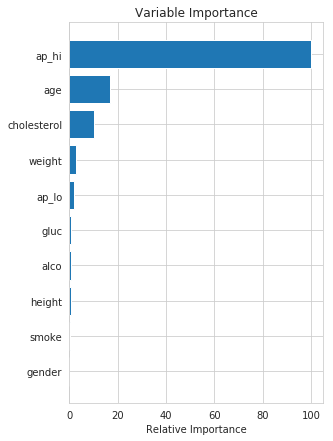

In [0]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_clean.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [0]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
gbc = ensemble.GradientBoostingClassifier(**params)

print('Full Data')
print('All features')
full_gbc_all = model_analysis(gbc, X_full, y_full)
print()
print('PCA')
full_gbc_pca = model_analysis(gbc, x_pca_full, y_full)
print()
print('K_best')
full_gbc_kbest = model_analysis(gbc, Kbest_X_full, y_full)
gbc_results_full = [full_gbc_all, full_gbc_pca, full_gbc_kbest]

Full Data
All features
[[8070 2419]
 [3087 7424]]
tn: 8070 fp: 2419 fn: 3087 tp: 7424
accuracy: 0.7378095238095238
f1: 0.7294880613147293

precent of 1s in target test: 0.5005238095238095
precent of 0s in target test: 0.4994761904761905
null accuracy: 0.5005238095238095

PCA
[[8277 2366]
 [3176 7181]]
tn: 8277 fp: 2366 fn: 3176 tp: 7181
accuracy: 0.7360952380952381
f1: 0.7215635048231511

precent of 1s in target test: 0.4931904761904762
precent of 0s in target test: 0.5068095238095238
null accuracy: 0.5068095238095238

K_best
[[8142 2432]
 [3074 7352]]
tn: 8142 fp: 2432 fn: 3074 tp: 7352
accuracy: 0.7378095238095238
f1: 0.7275606135576447

precent of 1s in target test: 0.49647619047619046
precent of 0s in target test: 0.5035238095238095
null accuracy: 0.5035238095238095


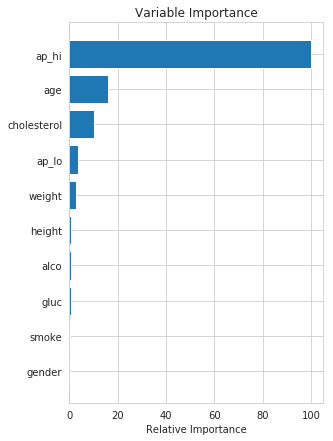

In [0]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_full.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### SVC

In [0]:
svc = SVC()

# Normalize data for Euclidean geometry

print('Cleaned data')
print('All features')
clean_svc_all = model_analysis(svc, normalize(X_clean), y_clean)
print()
print('PCA')
clean_svc_pca = model_analysis(svc, normalize(x_pca_clean), y_clean)
print()
print('K_best')
clean_svc_kbest = model_analysis(svc, normalize(Kbest_X_clean), y_clean)
svc_results_clean = [clean_svc_all, clean_svc_pca, clean_svc_kbest]

Cleaned data
All features
[[8257 2167]
 [3868 6133]]
tn: 8257 fp: 2167 fn: 3868 tp: 6133
accuracy: 0.7045287637698898
f1: 0.6702365990929456

precent of 1s in target test: 0.48964504283965726
precent of 0s in target test: 0.5103549571603427
null accuracy: 0.5103549571603427

PCA
[[8197 2155]
 [3543 6530]]
tn: 8197 fp: 2155 fn: 3543 tp: 6530
accuracy: 0.7210281517747859
f1: 0.6962362725237232

precent of 1s in target test: 0.4931701346389229
precent of 0s in target test: 0.5068298653610771
null accuracy: 0.5068298653610771

K_best
[[8258 2162]
 [3914 6091]]
tn: 8258 fp: 2162 fn: 3914 tp: 6091
accuracy: 0.7025214198286414
f1: 0.6672143717822325

precent of 1s in target test: 0.48984088127294984
precent of 0s in target test: 0.5101591187270502
null accuracy: 0.5101591187270502


In [0]:
svc = SVC()

# Normalize data for Euclidean geometry

print('Full Data')
print('All features')
full_svc_all = model_analysis(svc, normalize(X_full), y_full)
print()
print('PCA')
full_svc_pca = model_analysis(svc, normalize(x_pca_full), y_full)
print()
print('K_best')
full_svc_kbest = model_analysis(svc, normalize(Kbest_X_full), y_full)
svc_results_full = [full_svc_all, full_svc_pca, full_svc_kbest]

Full Data
All features
[[8313 2128]
 [4039 6520]]
tn: 8313 fp: 2128 fn: 4039 tp: 6520
accuracy: 0.7063333333333334
f1: 0.6789191440620608

precent of 1s in target test: 0.5028095238095238
precent of 0s in target test: 0.4971904761904762
null accuracy: 0.5028095238095238

PCA
[[8472 1927]
 [3872 6729]]
tn: 8472 fp: 1927 fn: 3872 tp: 6729
accuracy: 0.7238571428571429
f1: 0.6988627512073531

precent of 1s in target test: 0.5048095238095238
precent of 0s in target test: 0.4951904761904762
null accuracy: 0.5048095238095238

K_best
[[8284 2228]
 [3965 6523]]
tn: 8284 fp: 2228 fn: 3965 tp: 6523
accuracy: 0.7050952380952381
f1: 0.6781017724413951

precent of 1s in target test: 0.49942857142857144
precent of 0s in target test: 0.5005714285714286
null accuracy: 0.5005714285714286


### Cleaned Dataset Results

In [0]:
test = pd.DataFrame(index=['all', 'pca', 'kbest'])
test['BernoulliNB'] = bnb_results_clean
test['Log Reg'] = logreg_results_clean
test['RFC'] = rfc_results_clean
test['KNN'] = knn_results_clean
test['GBC'] = gbc_results_clean
test['SVC'] = svc_results_clean

test

,BernoulliNB,Log Reg,RFC,KNN,GBC,SVC
all,"accuracy: 0.5201, f1: 0.2866","accuracy: 0.7263, f1: 0.7073","accuracy: 0.6906, f1: 0.6726","accuracy: 0.6778, f1: 0.6669","accuracy: 0.7375, f1: 0.7229","accuracy: 0.7045, f1: 0.6702"
pca,"accuracy: 0.7043, f1: 0.6858","accuracy: 0.7285, f1: 0.707","accuracy: 0.6929, f1: 0.6735","accuracy: 0.682, f1: 0.6728","accuracy: 0.7297, f1: 0.7132","accuracy: 0.721, f1: 0.6962"
kbest,"accuracy: 0.518, f1: 0.3038","accuracy: 0.7285, f1: 0.7051","accuracy: 0.6928, f1: 0.6757","accuracy: 0.6774, f1: 0.6633","accuracy: 0.7344, f1: 0.7189","accuracy: 0.7025, f1: 0.6672"


### Full Dataset Results

In [0]:
test_full = pd.DataFrame(index=['all', 'pca', 'kbest'])
test_full['BernoulliNB'] = bnb_results_full
test_full['Log Reg'] = logreg_results_full
test_full['RFC'] = rfc_results_full
test_full['KNN'] = knn_results_full
test_full['GBC'] = gbc_results_full
test_full['SVC'] = svc_results_full

test_full

,BernoulliNB,Log Reg,RFC,KNN,GBC,SVC
all,"accuracy: 0.5157, f1: 0.2978","accuracy: 0.716, f1: 0.7033","accuracy: 0.7031, f1: 0.6855","accuracy: 0.6793, f1: 0.6701","accuracy: 0.7378, f1: 0.7295","accuracy: 0.7063, f1: 0.6789"
pca,"accuracy: 0.7208, f1: 0.7076","accuracy: 0.7213, f1: 0.7065","accuracy: 0.695, f1: 0.6785","accuracy: 0.6839, f1: 0.6814","accuracy: 0.7361, f1: 0.7216","accuracy: 0.7239, f1: 0.6989"
kbest,"accuracy: 0.518, f1: 0.2982","accuracy: 0.7131, f1: 0.6989","accuracy: 0.699, f1: 0.6857","accuracy: 0.6814, f1: 0.6738","accuracy: 0.7378, f1: 0.7276","accuracy: 0.7051, f1: 0.6781"


### Conclusion

Overall the dfference between the clean and full dataset is minimal as well as the difference between models which used featured selection versus models that took the full dataset with the exception of the BernoulliNB Classifier. And in this case, only PCA performed well. Gradient Boosting Classifier performed the best out of the models, but only by a relatively small amount. There is not much variance between the other models (except Bernoulli).   